In [1]:
# Customization imports

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

import time

# Export dataFrame's as images
import dataframe_image as dfi

In [2]:
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures, OrdinalEncoder

from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.metrics import auc as auc_temp

In [3]:
# import my utility methods for this project
import utils_practical_2 as my_utils

In [4]:
# Configure logging
import logging
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

# logging.getLogger().setLevel(logging.DEBUG)
# logging.getLogger().setLevel(logging.INFO)

In [5]:
# Global format rules

# Clean up axes labels
axes_fonts = {'fontweight': 'bold'}
title_fonts = {'fontweight': 'bold', 'fontsize': 14}

# Seaborn over-rides
sns.set_theme(style='darkgrid')

# On to Modeling ...

**This notebook picks up from the Data Investigation (see ```DataInvestigation.ipynb```)**

[Local file](DataInvestigation.ipynb)
[Github](https://github.com/fazeelgm/UCB_ML_AI_PracticalApp_II/blob/main/DataInvestigation.ipynb)

## Data Cleanup

The data cleansing results are as follows:

In [9]:
# vehicles_raw, vehicles_cleansed = my_utils.get_cleansed_data()

In [10]:
# vehicles_cleansed.info()

# On to Modeling ...

While investigating the different features of our dataset during the data investigation, I learned two things:

1. The data is very noisy with extreme outliers - I removed null data and outliers as much as possible
   * 66,180 samples were dropped, preserving 84.50% of the original data
3. To aid in this effort, I researched the used car marketplace to get some idea of pricing, important features that drive price and potential inventory segments

## Initial Hypothesis

Based on Price inspection, a potential hypothesis arose that the used car inventory is _segmented_ based on the following price bands:

![](images/candidate-price-segments.png)

In addition, market research suggested that typical used cars can be categoriezed into price ranges like Budget, Mid, Luxury, etc. that will be based on feature groups. I looked at ```<price, year, condition, odometer>``` combinations and saw that there was clustering behavior as shown by the scatter plots below:

![](images/scatter-price-odo-condition-budget.png)
![](images/scatter-price-odo-year-entry.png)

So, I will now use clustering techniques to see if we can observe natural clustering of features in our sample population.

# Final Modeling

## Data Cleaning

In [15]:
vehicles_raw, vehicles_cleansed = my_utils.get_cleansed_data()

Reading data/vehicles.csv ... Done: (426880, 18)

Cleansing price column ... 
... Removing price outliers using ModZ method ... 
... ModZ: 9450.0, med: 13950.0, const: 0.6745
... Time: 0.24738407135009766
... Removed 5,790 outliers
... Removing cars with price = 0 ...  Removed 32,895 rows
Done: (421090, 19) -> (388195, 19)

DropNA from columns: 
... year: 1,029 rows (0.27% of total): 388,195 -> 387,166
... manufacturer: 16,609 rows (4.28% of total): 388,195 -> 371,586
... fuel: 19,173 rows (4.94% of total): 388,195 -> 369,022
... title_status: 26,730 rows (6.89% of total): 388,195 -> 361,465
... odometer: 28,960 rows (7.46% of total): 388,195 -> 359,235
... transmission: 30,742 rows (7.92% of total): 388,195 -> 357,453
Done: (388195, 19) -> (360700, 19)

Dropping columns: ['mod_zscore', 'id', 'model']
... mod_zscore
... id
... model
Done: (360700, 19) -> (360700, 16)

Data Transformations:
... year float -> int: Done
... odometer float -> int: Done

Category Transformations:
... Conver

In [16]:
vehicles_cleansed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 360700 entries, 27 to 426879
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype   
---  ------        --------------   -----   
 0   region        360700 non-null  object  
 1   price         360700 non-null  int64   
 2   year          360700 non-null  int64   
 3   manufacturer  360700 non-null  category
 4   condition     223668 non-null  category
 5   cylinders     213522 non-null  category
 6   fuel          360700 non-null  category
 7   odometer      360700 non-null  int64   
 8   title_status  360700 non-null  category
 9   transmission  360700 non-null  category
 10  VIN           219818 non-null  object  
 11  drive         252582 non-null  category
 12  size          104338 non-null  category
 13  type          282300 non-null  category
 14  paint_color   257706 non-null  category
 15  state         360700 non-null  category
dtypes: category(11), int64(3), object(2)
memory usage: 20.3+ MB


In [17]:
vehicles_cleansed.columns

Index(['region', 'price', 'year', 'manufacturer', 'condition', 'cylinders',
       'fuel', 'odometer', 'title_status', 'transmission', 'VIN', 'drive',
       'size', 'type', 'paint_color', 'state'],
      dtype='object')

In [18]:
# Create a copy of the clean data
data = vehicles_cleansed.copy()

In [19]:
# Remove unwanted columns
drop_cols = ['region', 'manufacturer', 'VIN', 'paint_color', 'state', 'size']
data.drop(columns=drop_cols, inplace=True)

In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 360700 entries, 27 to 426879
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype   
---  ------        --------------   -----   
 0   price         360700 non-null  int64   
 1   year          360700 non-null  int64   
 2   condition     223668 non-null  category
 3   cylinders     213522 non-null  category
 4   fuel          360700 non-null  category
 5   odometer      360700 non-null  int64   
 6   title_status  360700 non-null  category
 7   transmission  360700 non-null  category
 8   drive         252582 non-null  category
 9   type          282300 non-null  category
dtypes: category(7), int64(3)
memory usage: 13.4 MB


In [21]:
# data['size'].value_counts()

In [22]:
# data.shape[0] - data['size'].value_counts().sum()

In [23]:
# data[data['size'].isna()]

In [24]:
# data.query('size == ""')['size'].value_counts().sum()

In [25]:
# remove nulls before splitting data

dropna_cols = ['condition', 'cylinders', 'drive', 'type']

print('Dropping nulls: {} -> '.format(data.shape), end='')
# data.dropna(subset=['condition', 'cylinders', 'drive', 'size', 'type'], axis='index', inplace=True)
data.dropna(subset=dropna_cols, axis='index', inplace=True)
print(' {}'.format(data.shape))

Dropping nulls: (360700, 10) ->  (122682, 10)


In [26]:
data.columns

Index(['price', 'year', 'condition', 'cylinders', 'fuel', 'odometer',
       'title_status', 'transmission', 'drive', 'type'],
      dtype='object')

## Feature Transformation for Modeling

### Create Train/Test splits

In [29]:
X = data.drop('price', axis='columns')
y = data['price']

# OneHot Encode the features
X = pd.get_dummies(X, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [30]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 122682 entries, 31 to 426878
Data columns (total 39 columns):
 #   Column                   Non-Null Count   Dtype
---  ------                   --------------   -----
 0   year                     122682 non-null  int64
 1   odometer                 122682 non-null  int64
 2   condition_fair           122682 non-null  bool 
 3   condition_good           122682 non-null  bool 
 4   condition_like new       122682 non-null  bool 
 5   condition_new            122682 non-null  bool 
 6   condition_salvage        122682 non-null  bool 
 7   cylinders_12 cylinders   122682 non-null  bool 
 8   cylinders_3 cylinders    122682 non-null  bool 
 9   cylinders_4 cylinders    122682 non-null  bool 
 10  cylinders_5 cylinders    122682 non-null  bool 
 11  cylinders_6 cylinders    122682 non-null  bool 
 12  cylinders_8 cylinders    122682 non-null  bool 
 13  cylinders_other          122682 non-null  bool 
 14  fuel_electric            122682 non-null

### Feature Scaling

In [32]:
# Scale the data
logging.debug('Scaling data')
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

## Baseline Regression Models

In [34]:
models = {
    'LinearRegression' : LinearRegression(),
    'Ridge' : Ridge(alpha=1.0),
    'Lasso' : Lasso(alpha=0.1)
}

# save results for tabulation
results_baseline = []

In [35]:
# Evaluate models
def get_model_metrics_as_results(model_name, y_preds, y_test, score):
    """
    Build standardized results row given the predictions and y_test values

    :param model_name: Model name for labeling the row in the table
    :param y_preds: Predictions of y_test
    :param y_test: Test y
    :param score: Model Score is passed in
    :return: Returns single row of results summary table containing:
    
        [model_name, MAE, MSE, RMSE, R2_Score]
    """

    start_time = time.time()

    logging.debug(f'Working on {model_name}')

    # get metrics
    mae = mean_absolute_error(y_preds, y_test)
    mse = mean_squared_error(y_preds, y_test)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_preds, y_test)

    lapse = time.time() - start_time
    
    logging.debug(f'... {model_name}: MAE: {mae:,.4f}, MSE: {mse:,.4f}, RMSE: {rmse:,.4f}, R2: {r2:,.4f}, Score: {score:,.4f}, time: {lapse:,.4f}')

    return [model_name, mae, mse, rmse, score]

In [36]:
results_baseline = []

# iterate over the models and build results DF
for model in models:

    start_time = time.time()
    print(f'Working on {model} ... ', end='')

    models[model].fit(X_train, y_train)
    
    y_preds = models[model].predict(X_test)

    model_name=model
    score = models[model].score(X_test, y_test)

    results_baseline.append(get_model_metrics_as_results(model_name, y_preds, y_test, score))

    print(f'Done with {model} ({time.time() - start_time:,.4f} sec)')

Working on LinearRegression ... Done with LinearRegression (0.3840 sec)
Working on Ridge ... Done with Ridge (0.3358 sec)
Working on Lasso ... Done with Lasso (4.7656 sec)


In [37]:
# Generate results table
results_baseline_df = pd.DataFrame(results_baseline, 
                                   columns=['Model','MAE', 'MSE', 'RMSE', 'R2 Score']
                                  ).set_index('Model')


# Export results for README
results_baseline_df_styled = my_utils.df_style_floats(results_baseline_df)
dfi.export(results_baseline_df_styled, 'images/results_baseline_table.png')

print('RESULTS: Baseline metrics without any optimization\n')
results_baseline_df_styled

RESULTS: Baseline metrics without any optimization



,MAE,MSE,RMSE,R2 Score
Model,,,,
LinearRegression,"6,014.3335","71,512,923.1698","8,456.5314",0.5274
Ridge,"6,014.3032","71,512,698.2967","8,456.5181",0.5274
Lasso,"6,014.3241","71,512,622.6444","8,456.5136",0.5274


All the models performed very closely without any clear winners. Given the target variable measurement unit, price in dollars per car:

* All the models showed roughly $8,287 (RMSE) average difference between the predicted and actual prices from the test dataset that was not used for the training of the model
* The R2 Score shows thay they each captured 42.77% of the variance in the price

We will now optimize the models to see if we can improve the results and pick a clear winner.

## Model Tuning: Hyperparameter Tuning and Cross Validation

In [40]:
models = {
    'Ridge': Ridge(),
    'Lasso': Lasso()
}

param_grid = {
    'Ridge': {'alpha': [0.1, 1.0, 10.0, 100.0]},
    'Lasso': {'alpha': [0.01, 0.1, 1.0, 10.0]}    
}

In [41]:
# logging.getLogger().setLevel(logging.DEBUG)

In [42]:
# save results for tabulation
results_tuned = []
best_models = {}
best_params = {}
cv_scores = {}
cv_mses = {}

# Run cross validation using GridSearchCV
cv=5
for model in models:
    clf = models[model]
    start_time = time.time()

    print(f'Working on {model}, params: {param_grid[model]} ... ', end='')
    logging.debug(f'Working on {model} - clf: {type(clf)}, params: {param_grid[model]}')
    grid = GridSearchCV(clf, param_grid=param_grid[model], cv=cv, scoring='neg_mean_squared_error')
    grid.fit(X_train_scaled, y_train)

    
    # Save the tuning metrics for this model class
    best_models[model] = grid.best_estimator_
    cv_score = cross_val_score(clf, X_train_scaled, y_train, cv=cv, scoring='neg_mean_squared_error')
    cv_scores[model] = cv_score
    cv_mses[model] = -np.mean(cv_score)
    best_params[model] = grid.best_params_
    
    logging.debug(f'Best alpha: {grid.best_params_}')
    logging.debug(f'CV Score: {cv_score}')
    logging.debug(f'CV MSE: {-np.mean(cv_score)}')
    logging.debug(f'CV Best Score: {-grid.best_score_}')
    logging.debug(f'CV Best RMSE: {np.sqrt(-grid.best_score_)}')

    y_preds = grid.best_estimator_.predict(X_test_scaled)
    score = grid.score(X_test_scaled, y_test)
    r2 = r2_score(y_test, y_preds)
    logging.debug(f'Score: {score}, r2: {r2}')

    results_tuned.append(get_model_metrics_as_results(model, y_preds, y_test, r2))

    print(f'Done with {model} ({time.time() - start_time:,.4f} sec)')

logging.getLogger().setLevel(logging.INFO)

Working on Ridge, params: {'alpha': [0.1, 1.0, 10.0, 100.0]} ... Done with Ridge (2.0967 sec)
Working on Lasso, params: {'alpha': [0.01, 0.1, 1.0, 10.0]} ... Done with Lasso (51.5549 sec)


We add LinearRegression to the results manually as there is no need for cross-validation

In [44]:
# Handle LinearRegression manually

# logging.getLogger().setLevel(logging.DEBUG)

model='LinearRegression'

start_time = time.time()
print(f'Working on {model} ... ', end='')

linear_model = LinearRegression()

# Train Linear Regression model
linear_model.fit(X_train_scaled, y_train)

linear_cv_score = cross_val_score(linear_model, X_train_scaled, y_train, cv=cv, scoring='neg_mean_squared_error')
logging.debug(f'Linear Regression CV MSE: {-np.mean(linear_cv_score)}')

# This is the best estimator for LinearRegression as there is no tuning
best_models[model] = linear_model
cv_scores[model] = linear_cv_score
cv_mses[model] = -np.mean(linear_cv_score)
best_params[model] = ''

# Make predictions
linear_pred = linear_model.predict(X_test_scaled)

results_tuned.append(get_model_metrics_as_results(model, linear_pred, y_test, r2_score(y_test, linear_pred)))

print(f'Done with {model} ({time.time() - start_time:,.4f} sec)')

# logging.getLogger().setLevel(logging.INFO)

Working on LinearRegression ... Done with LinearRegression (1.8580 sec)


In [45]:
# Generate results table
results_tuned_df = pd.DataFrame(results_tuned,
                                columns=['Model - Tuned','MAE', 'MSE', 'RMSE', 'R2 Score']
                               ).set_index('Model - Tuned')

# Add BestParams as a new column
results_tuned_df['CV MSE'] = results_tuned_df.index.map(cv_mses)
results_tuned_df['CV Best Params'] = results_tuned_df.index.map(best_params)

# Export results for README
results_tuned_df_styled = my_utils.df_style_floats(results_tuned_df)
dfi.export(results_tuned_df_styled, 'images/results_tuned_table.png')

## Model Assessment

### Best Model

In [48]:
print('RESULTS: Baseline Model metrics without any optimization\n')
results_baseline_df_styled

RESULTS: Baseline Model metrics without any optimization



,MAE,MSE,RMSE,R2 Score
Model,,,,
LinearRegression,"6,014.3335","71,512,923.1698","8,456.5314",0.5274
Ridge,"6,014.3032","71,512,698.2967","8,456.5181",0.5274
Lasso,"6,014.3241","71,512,622.6444","8,456.5136",0.5274


In [49]:
print('RESULTS: Optimized Model results after hyperparameter tuning and cross-validation\n')
results_tuned_df_styled

RESULTS: Optimized Model results after hyperparameter tuning and cross-validation



,MAE,MSE,RMSE,R2 Score,CV MSE,CV Best Params
Model - Tuned,,,,,,
Ridge,"5,960.3549","71,291,107.9996","8,443.4062",0.5288,"73,109,685.4499",{'alpha': 100.0}
Lasso,"5,961.6817","71,305,006.3838","8,444.2292",0.5288,"73,108,960.5920",{'alpha': 10.0}
LinearRegression,"5,959.6608","71,289,759.7592","8,443.3263",0.5289,"73,109,696.7695",


In [50]:
best_model_name = results_tuned_df['R2 Score'].idxmax()
best_model = best_models[best_model_name]
print('Best Model: {}\n\tR2 Score: {:,.2f}%\n\tRMSE: {}'
      .format(best_model_name, 
              float(results_tuned_df.loc[best_model_name]['R2 Score']) * 100, 
              results_tuned_df.loc[best_model_name]['RMSE']))

Best Model: LinearRegression
	R2 Score: 52.89%
	RMSE: 8,443.3263


Again, all the models performed very closely without any clear winners. 

However, the optimized Ridge Model with alpha=10.0 showed the least average difference between predicted and actual prices (\\$8,281.94 vs \\$8,287 RMSE) and a captured more variance across the features (42.85%  vs 42.77% R2 Score) for the **best performing Ridge model**. 

In addition, the base price of a car is given by the y-intercept for the model: $22,490.54, with each feature adding or subtracting from this value based on the training features.

### Visualizing Actual vs Predicted Prices

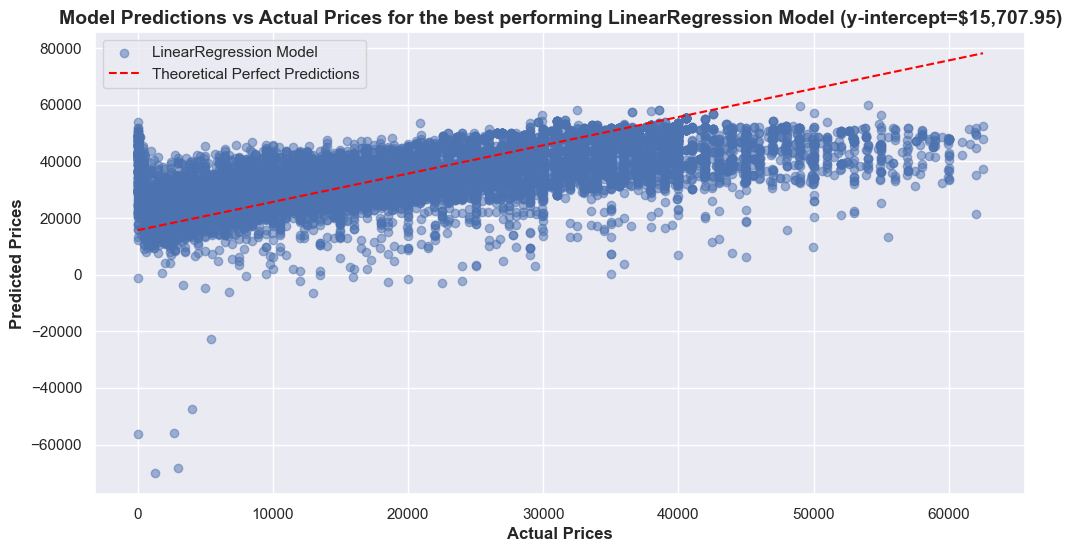

In [53]:
# Plot predictions
y_preds = best_model.predict(X_test_scaled)
y_intercept = best_model.intercept_

# Adjust for the y-intercept
y_preds = np.add(y_preds, y_intercept)
perfect_pt_1 = [min(y_test), max(y_test)]
perfect_pt_2 = [min(y_test), max(y_test)] + y_intercept

plt.figure(figsize=(12, 6))
plt.scatter(x=y_test, y=y_preds, label=f'{best_model_name} Model', alpha=0.5)
plt.plot(perfect_pt_1, perfect_pt_2, color='red', linestyle='--', label='Theoretical Perfect Predictions')

plt.xlabel('Actual Prices', fontdict=axes_fonts)
plt.ylabel('Predicted Prices', fontdict=axes_fonts)
plt.title(f'Model Predictions vs Actual Prices for the best performing {best_model_name} Model (y-intercept=${y_intercept:,.2f})', 
          fontdict=title_fonts)
plt.legend()

plt.savefig('images/scatter-optimized-preds-v-test.png')
plt.show()

In [54]:
# # # How to get the list of available Displays for my version of sklearn
# # from sklearn.utils.discovery import all_displays

# # displays = all_displays()
# # displays

# ### ValidationCurveDisplay

# from sklearn.model_selection import ValidationCurveDisplay

# param_name, param_range = 'alpha', [0.1, 1.0, 10.0, 100.0]
# clf = Ridge()

# ValidationCurveDisplay.from_estimator(clf, X_test_scaled, y_test,
#                                       param_name=param_name,
#                                       param_range=param_range,
#                                       scoring='neg_mean_squared_error',
#                                       cv=5, n_jobs=-1)
# plt.show()

### PredictionErrorDisplay: Residuals Comparison

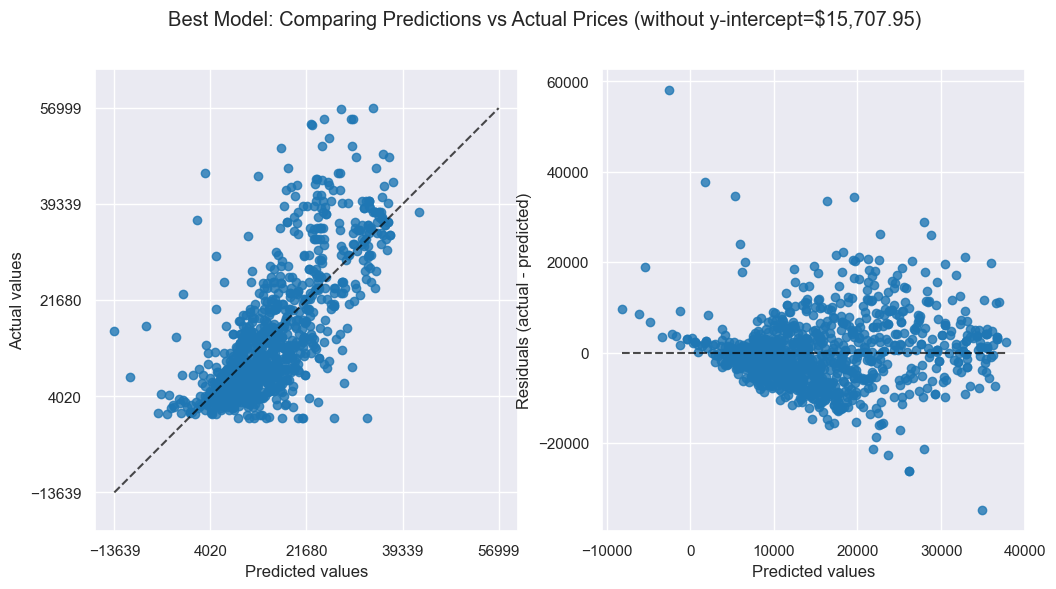

In [56]:
from sklearn.metrics import PredictionErrorDisplay

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
PredictionErrorDisplay.from_estimator(best_model, X_test_scaled, y_test, ax=axes[0], kind="actual_vs_predicted")
PredictionErrorDisplay.from_estimator(best_model, X_test_scaled, y_test, ax=axes[1], kind="residual_vs_predicted")

plt.suptitle(f'Best Model: Comparing Predictions vs Actual Prices (without y-intercept=${y_intercept:,.2f})')
plt.savefig('images/optimized-PredictionErrorDisplay.png')
plt.show()

### Interpreting the Model Results

In [58]:
# build the feature importance DF

feature_names = X.columns

feature_imp = []
for feature, coef in zip(feature_names, best_model.coef_):
    if coef != 0:
        # print(f'{feature}: {coef}')
        feature_imp.append([feature, coef])

feature_imp_df = pd.DataFrame(data=feature_imp, columns=['Feature', 'Coefficient'])#.set_index('Feature')
feature_imp_df['Importance'] = np.abs(feature_imp_df.Coefficient)

# Sort the DF
feature_imp_df = feature_imp_df.sort_values(by='Importance', ascending=False)

# Add cumulative importance
feature_imp_df['Cumulative Importance'] = feature_imp_df['Importance'].cumsum() / feature_imp_df['Importance'].sum()
feature_imp_df['Percent Contribution'] = feature_imp_df['Cumulative Importance'] * 100

print(f'Impact of each feature to the Base Price: ${y_intercept:,.2f} (y-intercept)')
my_utils.df_style_floats(feature_imp_df[['Feature', 'Coefficient', 'Percent Contribution']].set_index('Feature').rename(columns={'Coefficient':'Price Impact'}).head())
# feature_imp_df_styled = my_utils.df_style_floats(feature_imp_df)
# feature_imp_df_styled

Impact of each feature to the Base Price: $15,707.95 (y-intercept)


,Price Impact,Percent Contribution
Feature,,
transmission_other,"3,904.4572",12.9363
year,"3,715.3842",25.2462
fuel_gas,"-2,236.9650",32.6577
cylinders_8 cylinders,"2,030.9523",39.3867
drive_fwd,"-1,889.2489",45.6462


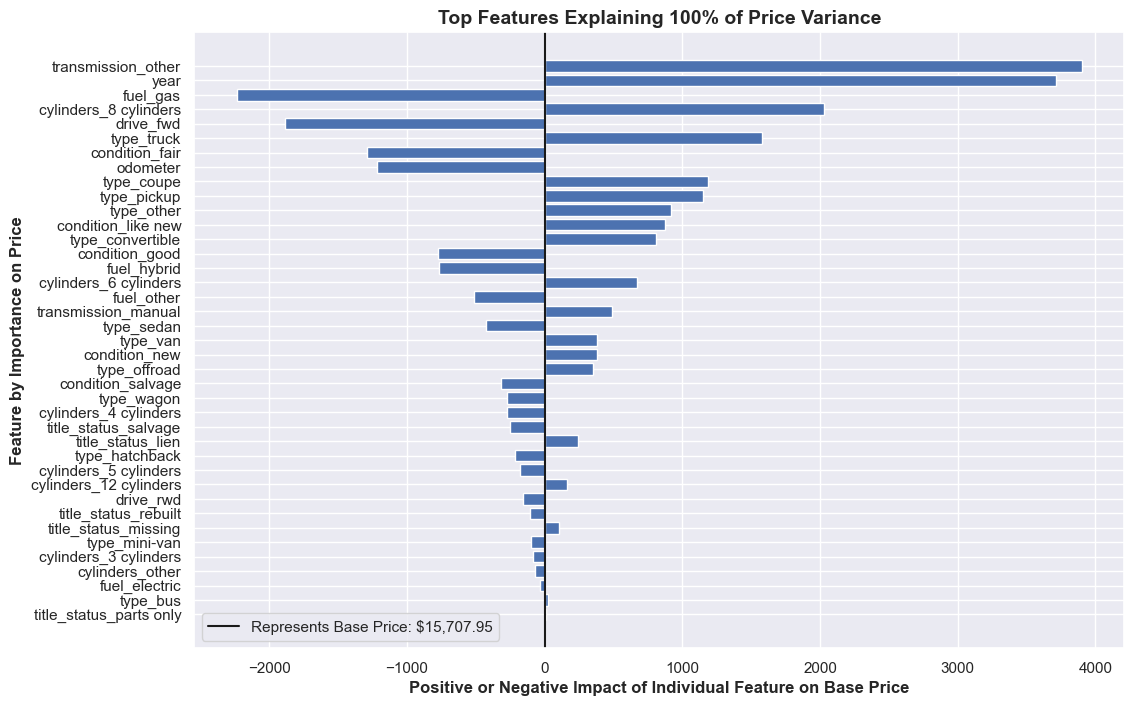

In [59]:
# Top features that explain X% of the variance
top_n = 1
top_features = feature_imp_df[feature_imp_df['Cumulative Importance'] <= top_n]

# Plot feature importance
plt.figure(figsize=(12, 8))
plt.barh(top_features['Feature'], top_features['Coefficient'])
plt.axvline(x=0, color="k", linestyle="-", label=f'Represents Base Price: ${y_intercept:,.2f}')

plt.xlabel(f'Positive or Negative Impact of Individual Feature on Base Price', fontdict=axes_fonts)
plt.ylabel('Feature by Importance on Price', fontdict=axes_fonts)

plt.title(f'Top Features Explaining {top_n * 100:,.0f}% of Price Variance', fontdict=title_fonts)
plt.gca().invert_yaxis()
plt.savefig('images/feature_importance.png')
plt.legend(loc='lower left')
plt.show()

## Segmentation Analysis

In [61]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
price,122682.0,15703.010751,12307.162365,1.0,6000.00,11599.0,23499.0,62950.0
year,122682.0,2009.325093,9.872852,1900.0,2006.00,2012.0,2015.0,2022.0
odometer,122682.0,111334.860517,194099.198408,0.0,55656.25,103000.0,148221.0,10000000.0


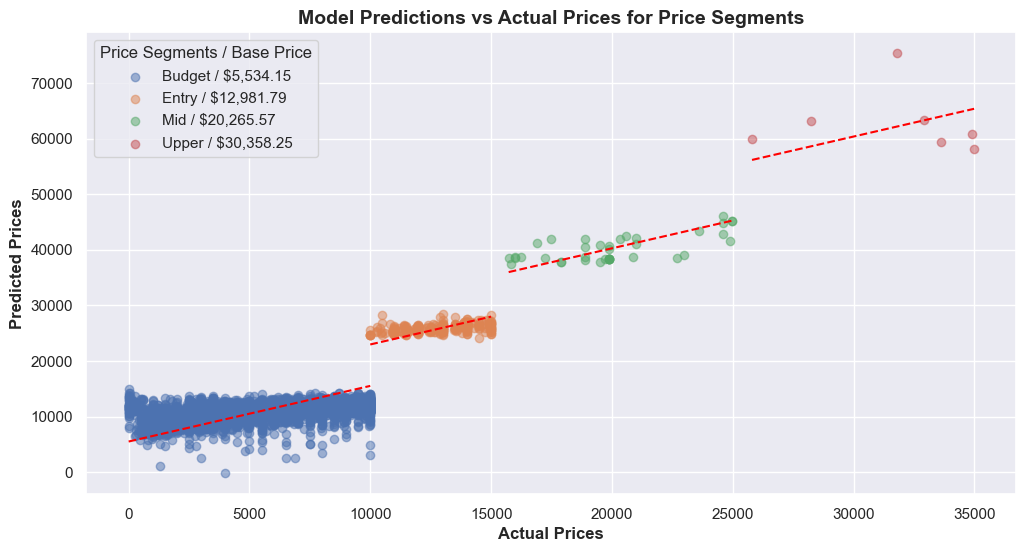

In [62]:
# logging.getLogger().setLevel(logging.DEBUG)

segments = {
    'Budget' : data.query('price <= 10000 and year <= 2016 and odometer >= 100000'),
    'Entry' : data.query('(price>=10000 and price<=15000) and (year>=2016 and year<=2019) and (odometer>=60000 and odometer<=100000)'),
    'Mid' : data.query('(price>=15000 and price<=25000) and (year>=2019 and year<=2021) and (odometer>=40000 and odometer<=60000)'),
    'Upper' : data.query('(price>=25000 and price<=35000) and (year>=2021 and year<=2023) and (odometer<=30000)'),
    'Premium' : data.query('(price>=35000) and (year>=2022) and (odometer<=20000)')
}

plt.figure(figsize=(12, 6))

# seg_preds = {}
for segment in segments:
    logging.debug(f'Segment: {segment}, #Samples: {len(segments[segment])}')

    if len(segments[segment]) <= 0:
        continue
    
    # Predict on the segment
    X = segments[segment].drop('price', axis='columns')
    y = segments[segment]['price']
    logging.debug(f'X: {X.shape} y: {y.shape}')

    # transform the data: OneHotEncoding
    X = pd.get_dummies(X, drop_first=True)

    # Scale the data
    X_scaled = scaler.fit_transform(X)
    logging.debug(f'X_scaled: {X_scaled.shape}')
    
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
    logging.debug(f'X_train: {X_train.shape} X_test: {X_test.shape} y_train: {y_train.shape} y_test: {y_test.shape}')

    best_model.fit(X_train, y_train)
    
    # Plot predictions
    y_preds = best_model.predict(X_test)
    score = best_model.score(X_test, y_test)
    r2 = r2_score(y_test, y_preds)
    y_intercept = best_model.intercept_
    logging.debug(f'Score: {score}, r2: {r2}, y_int: {y_intercept}')
    y_preds = y_preds + y_intercept
    # seg_preds[segment] = y_preds

    perfect_pt_1 = [min(y_test), max(y_test)]
    # perfect_pt_2 = [min(y_test), max(y_test)]
    perfect_pt_2 = [min(y_test), max(y_test)] + y_intercept
    plt.scatter(x=y_test, y=y_preds, label=f'{segment} / ${y_intercept:,.2f}', alpha=0.5)
    plt.plot(perfect_pt_1, perfect_pt_2, color='red', linestyle='--')#, label='Theoretical Perfect Predictions')

plt.xlabel('Actual Prices', fontdict=axes_fonts)
plt.ylabel('Predicted Prices', fontdict=axes_fonts)
plt.title(f'Model Predictions vs Actual Prices for Price Segments', fontdict=title_fonts)
plt.legend().set_title('Price Segments / Base Price')

plt.savefig('images/scatter-segments-preds-v-test.png')
plt.show()

logging.getLogger().setLevel(logging.INFO)

#### Single Segment

In [64]:
# Predict on the segment
seg = 'Mid'
X = segments[seg].drop('price', axis='columns')
y = segments[seg]['price']

# Transform the data
X = pd.get_dummies(X, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

best_model.fit(X_train_scaled, y_train)

LinearRegression()

In [65]:
print(X.shape, y.shape, X_train.shape, X_test.shape, y_train.shape, y_test.shape, X_train_scaled.shape)

(195, 39) (195,) (156, 39) (39, 39) (156,) (39,) (156, 39)


In [66]:
# Plot predictions
y_preds = best_model.predict(X_test_scaled)
score = best_model.score(X_test_scaled, y_test)
r2 = r2_score(y_test, y_preds)
logging.debug(f'Score: {score}, r2: {r2}')
y_intercept = best_model.intercept_

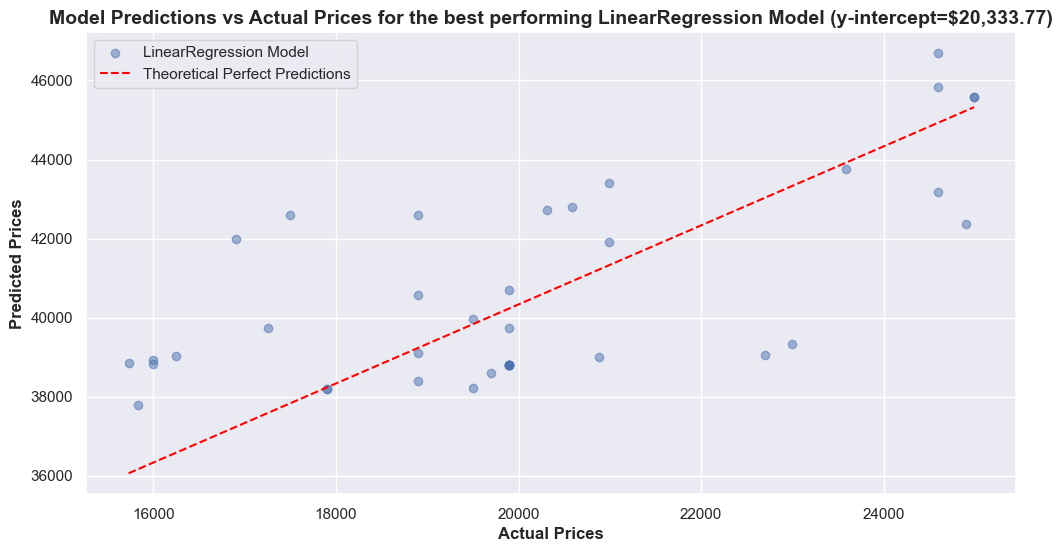

In [67]:
# Adjust for the y-intercept
y_preds = np.add(y_preds, y_intercept)
perfect_pt_1 = [min(y_test), max(y_test)]
perfect_pt_2 = [min(y_test), max(y_test)] + y_intercept

plt.figure(figsize=(12, 6))
plt.scatter(x=y_test, y=y_preds, label=f'{best_model_name} Model', alpha=0.5)
plt.plot(perfect_pt_1, perfect_pt_2, color='red', linestyle='--', label='Theoretical Perfect Predictions')
plt.xlabel('Actual Prices', fontdict=axes_fonts)
plt.ylabel('Predicted Prices', fontdict=axes_fonts)
plt.title(f'Model Predictions vs Actual Prices for the best performing {best_model_name} Model (y-intercept=${y_intercept:,.2f})', 
          fontdict=title_fonts)
plt.legend()
plt.savefig('images/scatter-optimized-preds-v-test.png')
plt.show()

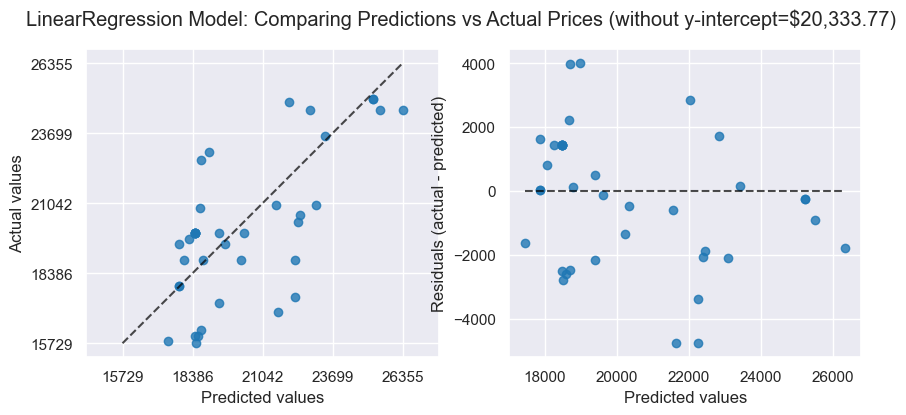

In [68]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
PredictionErrorDisplay.from_estimator(best_model, X_test_scaled, y_test, ax=axes[0], kind="actual_vs_predicted")
PredictionErrorDisplay.from_estimator(best_model, X_test_scaled, y_test, ax=axes[1], kind="residual_vs_predicted")

plt.suptitle(f'{best_model_name} Model: Comparing Predictions vs Actual Prices (without y-intercept=${y_intercept:,.2f})')
# plt.savefig('images/budget_predictions.png')
plt.show()